# ADC Analysis and Scipy

## Introduction

In an effort to beat the Lockdown Blues, I thought I would dabble in the world of embedded computers.  This was sparked by the recommendation on Hacker News for an EDX course "Embedded Systems - Shape The World: Microcontroller Input/Output".  It has proved quite an interesting exercise.

The course uses a TI ARM microcontroller TM4C123GH6PM to illustrate aspects of embedded design and programming.  Even though it is by now about five years old, there are still cheap Evaluation Kits from TI readily available.  In fact, you can buy all the components needed for the course as a bundle, even here in Australia.

## Culture Shock

It is quite a change to go from a high-level software engineering viewpoint, where you try to make abstractions of real world systems, to the world where you have to have a deep understanding of the architecture of the TM4C123GH6PM.  You are expected to turn modules on and off to save power, and here poking bits into arcane registers to modify simultaneously many aspects system behaviour is a way of life.  You can certainly come up with very concise C programs, where what would be a series of functions calls in my world, can be compactly expressed as a bit array, written into some control register.

## ADC
One of the facilities of the TM4C123GH6PM is an Analog-to-Digital Convertor, that is very flexible.  One of my exercises was to input an analog voltage, convert it to a 12 bit value, and send to a laptop (via the USB serial line) for display.  I took a set of observations of the input Voltage (via a multimeter), and the uploaded ADC value.  In doing this I noted that the output was quite noisy, with a jitter in last decimal digit of the ADC value.

I then repeated the experiment, but this time I configured the TM4C123GH6PM ADC to do hardware averaging of the values read.  The jitter seemed to be markedly reduced.

## Second Thoughts
Then I had second thoughts.  Maybe it wasn't noise, but (say) 50Hz ripple I was seeing in the reference voltage (unlikely I know), being sampled at random times.  In this case, the averaged ADC values would still drift up and down with the ripple.

## Scipy to the Rescue
I decided to use ```scipy``` to tell if the reduced jitter was really smaller in the averaged case.


-------------
## Notebook Setup

In [1]:
%load_ext lab_black

In [2]:
%load_ext watermark

In [3]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import numpy as np

from statsmodels.formula.api import ols

import statsmodels.api as sm

import scipy.stats as stats

import warnings

import sys
import os
import subprocess
import datetime
import platform
import datetime

D:\Anaconda3\envs\ac5-py37\lib\site-packages\statsmodels\compat\pandas.py:49: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  data_klasses = (pandas.Series, pandas.DataFrame, pandas.Panel)


-----
## Hardware Layout

The diagram below shows what must be the simplest Fritzing diagram ever.

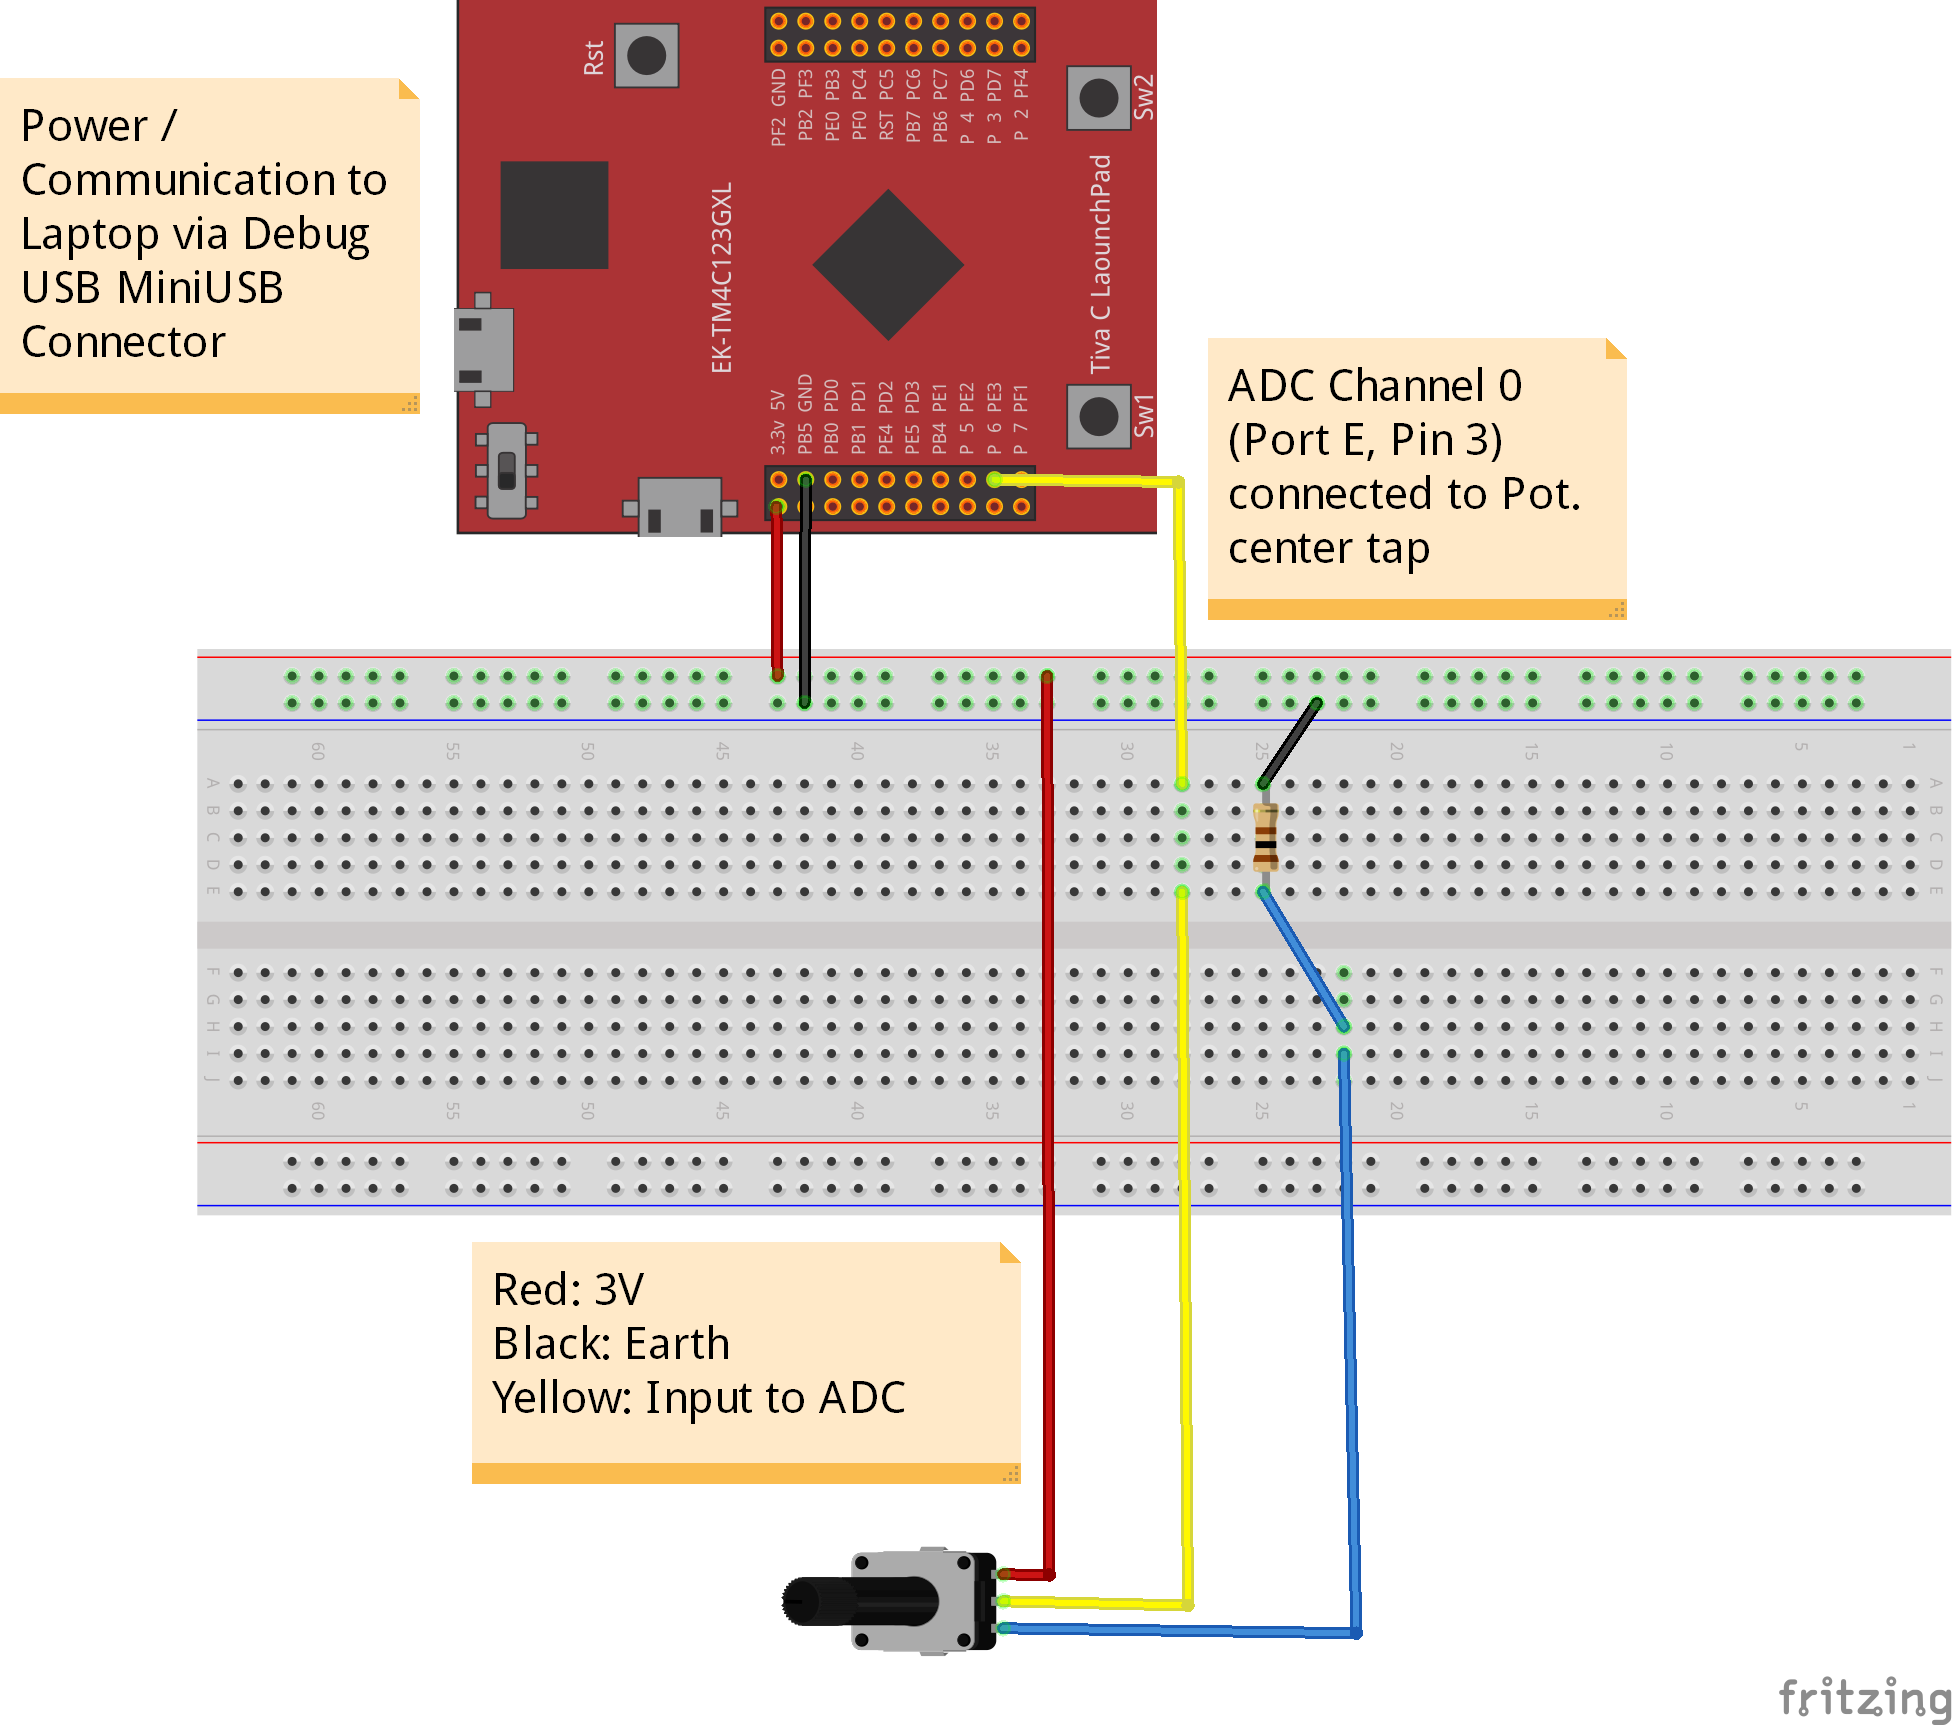

In [4]:
from IPython.display import Image

Image("images/TM4C123 ADC_bb.png")

---
## Single Sample ADC
We read the data from the single sample ADC values via ```pandas```, do some data cleanup, and use Seaborn to show the results

In [5]:
data = pd.read_csv('ADCRaw.txt')

data.head()

,Voltage,ADC
0,0.52,576
1,1.15,1423
2,1.75,2159
3,2.66,3348
4,2.13,2764


In [6]:
data.columns

Index(['Voltage', ' ADC '], dtype='object')

In [7]:
data.columns = ['Voltage', 'ADC']
data.sort_values(by='Voltage', inplace=True)

We use a different colors for raw data, and the fitted line.  I have no idea why the legend doesn't show all labels.  To make a point, I make the Confidence Interval to be the 99% range (and to make it easier to see)

D:\Anaconda3\envs\ac5-py37\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


Text(0.5, 1.0, 'Regplot: TM4C123GXL ADC Performance')

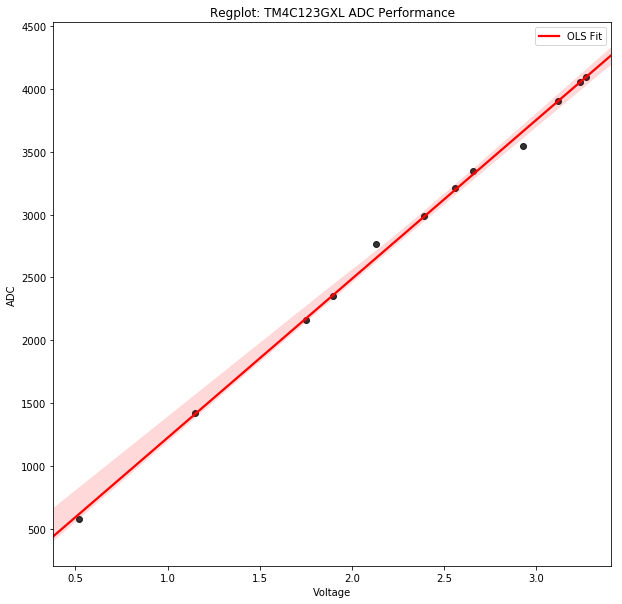

In [8]:
fig, ax = plt.subplots(figsize=(10, 10))

sns.regplot(
    'Voltage',
    'ADC',
    data=data,
    ci=99,
    scatter_kws={"color": "black", "label": "ADC Reading"},
    line_kws={"color": "red", "label": "OLS Fit"},
)
plt.legend(loc='best')
ax.set_title('Regplot: TM4C123GXL ADC Performance')

----
## Linear Regression

We now perform a linear regression, and plot the Observation Confidence Interval (not the mean CI)

In [9]:
res1 = ols('ADC ~ Voltage', data=data).fit()

In [10]:
res1.summary()

D:\Anaconda3\envs\ac5-py37\lib\site-packages\scipy\stats\stats.py:1394: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=12
  "anyway, n=%i" % int(n))


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    ADC   R-squared:                       0.998
Model:                            OLS   Adj. R-squared:                  0.997
Method:                 Least Squares   F-statistic:                     4326.
Date:                Sun, 07 Jun 2020   Prob (F-statistic):           1.61e-14
Time:                        09:27:23   Log-Likelihood:                -63.930
No. Observations:                  12   AIC:                             131.9
Df Residuals:                      10   BIC:                             132.8
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    -37.8856     46.917     -0.807      0.438    -142.424      66.653
Voltage     1262.8033     19.200     65.770      0.000    1220.023    1305.584
==============================================================================
Omnibus:                        4.851   Durbin-Watson:                   2.086
Prob(Omnibus):                  0.088   Jarque-Bera (JB):                1.740
Skew:                          -0.197   Prob(JB):                        0.419
Kurtosis:                       4.823   Cond. No.                         8.38
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

----
Note that the linear model is a very good one, explaining most of the variation in the data

Now, we plot the data, with CI lines (using the default ```alpha```)

In [11]:
gp = res1.get_prediction({'Voltage': data['Voltage']})


pred_df = gp.summary_frame()
pred_df.head(1)

,mean,mean_se,mean_ci_lower,mean_ci_upper,obs_ci_lower,obs_ci_upper
0,618.772083,37.662607,534.854564,702.689602,471.013716,766.530449


Text(0, 0.5, 'ADC Reading')

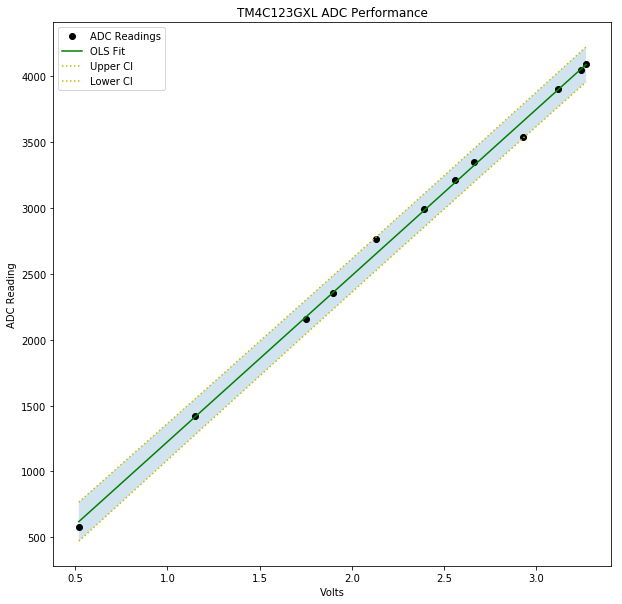

In [12]:
fig, ax = plt.subplots(figsize=(10, 10))
ax.plot(
    data['Voltage'], data['ADC'], 'ko', label='ADC Readings'
)
ax.plot(
    data['Voltage'], pred_df['mean'], 'g-', label='OLS Fit'
)
ax.plot(
    data['Voltage'],
    pred_df['obs_ci_upper'],
    'y:',
    label='Upper CI',
)
ax.plot(
    data['Voltage'],
    pred_df['obs_ci_lower'],
    'y:',
    label='Lower CI',
)
ax.fill_between(
    data['Voltage'],
    pred_df['obs_ci_lower'],
    pred_df['obs_ci_upper'],
    alpha=0.2,
)
ax.legend(loc='best')

ax.set_title('TM4C123GXL ADC Performance')
ax.set_xlabel('Volts')
ax.set_ylabel('ADC Reading')

---------------
## Hardware Averaged Readings

Again, we read the dataset of hardware averaged values, and clean it up

In [13]:
data2 = pd.read_csv('ADCAv64.txt')
data2.head(2)

,Voltage,ADC
0,0.53,658
1,1.15,1439


In [14]:
data2.columns = ['Voltage', 'ADC']
data2.sort_values(by='Voltage', inplace=True)

### Perform Linear Regression

In [15]:
res2 = ols('ADC ~ Voltage', data=data2).fit()

In [16]:
res2.summary()

D:\Anaconda3\envs\ac5-py37\lib\site-packages\scipy\stats\stats.py:1394: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=12
  "anyway, n=%i" % int(n))


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    ADC   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 4.377e+05
Date:                Sun, 07 Jun 2020   Prob (F-statistic):           1.53e-24
Time:                        09:27:24   Log-Likelihood:                -38.370
No. Observations:                  12   AIC:                             80.74
Df Residuals:                      10   BIC:                             81.71
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    -12.7591      4.278     -2.983      0.014     -22.291      -3.227
Voltage     1254.0907      1.896    661.611      0.000    1249.867    1258.314
==============================================================================
Omnibus:                        0.128   Durbin-Watson:                   2.721
Prob(Omnibus):                  0.938   Jarque-Bera (JB):                0.344
Skew:                          -0.034   Prob(JB):                        0.842
Kurtosis:                       2.173   Cond. No.                         6.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Plot Regression Results

We plot it twice, the second one with a wider CI band, but it is visually clear that the datapoints lie closer to the best-fit line

In [17]:
gp = res2.get_prediction({'Voltage': data2['Voltage']})


pred_df = gp.summary_frame()
pred_df.head(1)

,mean,mean_se,mean_ci_lower,mean_ci_upper,obs_ci_lower,obs_ci_upper
0,651.908963,3.403163,644.326243,659.491682,635.587551,668.230375


Text(0, 0.5, 'ADC Reading')

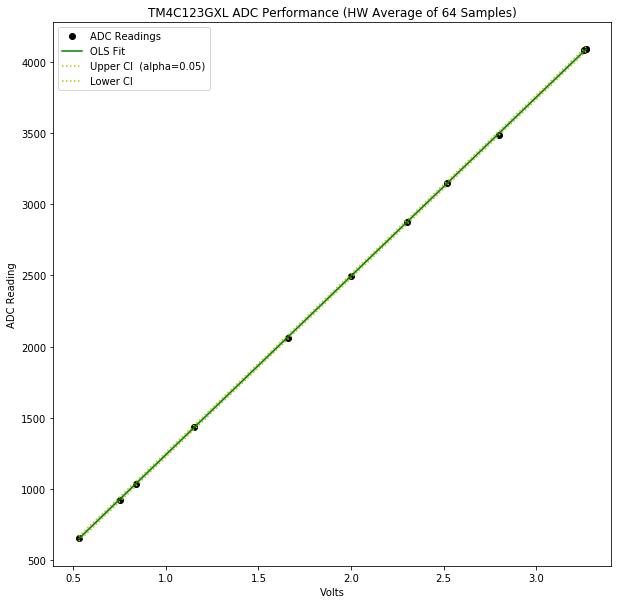

In [18]:
fig, ax = plt.subplots(figsize=(10, 10))
ax.plot(
    data2['Voltage'],
    data2['ADC'],
    'ko',
    label='ADC Readings',
)
ax.plot(
    data2['Voltage'], pred_df['mean'], 'g-', label='OLS Fit'
)
ax.plot(
    data2['Voltage'],
    pred_df['obs_ci_upper'],
    'y:',
    label='Upper CI  (alpha=0.05)',
)
ax.plot(
    data2['Voltage'],
    pred_df['obs_ci_lower'],
    'y:',
    label='Lower CI',
)
ax.fill_between(
    data2['Voltage'],
    pred_df['obs_ci_lower'],
    pred_df['obs_ci_upper'],
    alpha=0.2,
)
ax.legend(loc='best')
ax.set_title(
    'TM4C123GXL ADC Performance (HW Average of 64 Samples)'
)
ax.set_xlabel('Volts')
ax.set_ylabel('ADC Reading')

In [19]:
gp = res2.get_prediction({'Voltage': data2['Voltage']})


pred_df = gp.summary_frame(alpha=0.005)

In [20]:
pred_df.head(1)

,mean,mean_se,mean_ci_lower,mean_ci_upper,obs_ci_lower,obs_ci_upper
0,651.908963,3.403163,639.720854,664.097071,625.674688,678.143237


Text(0, 0.5, 'ADC Reading')

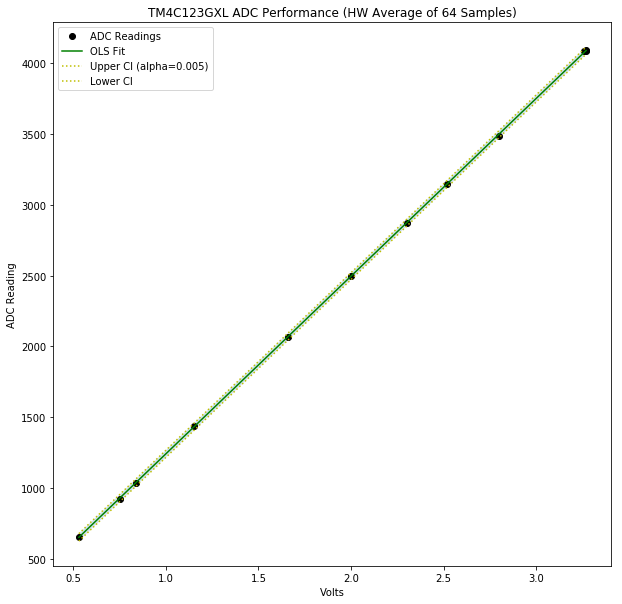

In [21]:
fig, ax = plt.subplots(figsize=(10, 10))
ax.plot(
    data2['Voltage'],
    data2['ADC'],
    'ko',
    label='ADC Readings',
)
ax.plot(
    data2['Voltage'], pred_df['mean'], 'g-', label='OLS Fit'
)
ax.plot(
    data2['Voltage'],
    pred_df['obs_ci_upper'],
    'y:',
    label='Upper CI (alpha=0.005)',
)
ax.plot(
    data2['Voltage'],
    pred_df['obs_ci_lower'],
    'y:',
    label='Lower CI',
)
ax.fill_between(
    data2['Voltage'],
    pred_df['obs_ci_lower'],
    pred_df['obs_ci_upper'],
    alpha=0.2,
)
ax.legend(loc='best')

ax.set_title(
    'TM4C123GXL ADC Performance (HW Average of 64 Samples)'
)
ax.set_xlabel('Volts')
ax.set_ylabel('ADC Reading')

### Plot Residuals

We now plot the residuals for the linear regressions on the two datasets

Text(0, 0.5, 'Residual')

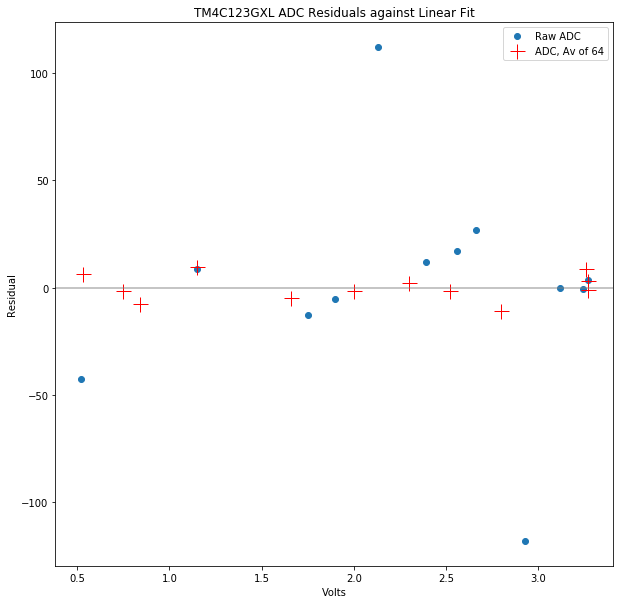

In [22]:
fig, ax = plt.subplots(figsize=(10, 10))

ax.plot(data['Voltage'], res1.resid, 'o', label='Raw ADC')
ax.plot(
    data2['Voltage'],
    res2.resid,
    'r+',
    label='ADC, Av of 64',
    markersize=15,
)
ax.legend(loc='best')
ax.axhline(0, color='grey', alpha=0.6)

ax.set_title('TM4C123GXL ADC Residuals against Linear Fit')
ax.set_xlabel('Volts')
ax.set_ylabel('Residual')

---
## Statistical Tests

We now apply a set of tests to check the the smaller residuals in the Hardware Averaged dataset regression are unlikely to have happened by chance.

### Bartlett Test

    "In statistics, Bartlett's test (see Snedecor and Cochran, 1989) is used to test if k samples are from populations with equal variances."

In [23]:
stats.bartlett(res1.resid, res2.resid)

BartlettResult(statistic=30.530672983835455, pvalue=3.286294124784678e-08)

In [24]:
f_crit = stats.chi2.ppf(0.95, 1)

f_crit

3.841458820694124

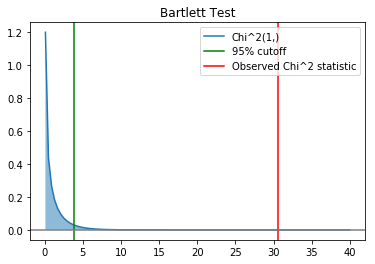

In [25]:
fstat = 30.53

x = np.linspace(0.1, 40, 100)

_ = plt.plot(
    x, stats.chi2.pdf(x, 1), '-', label=f'Chi^2(1,)'
)

_ = plt.fill_between(x, 0, stats.chi2.pdf(x, 1), alpha=0.5)

_ = plt.axvline(f_crit, color='green', label='95% cutoff')
_ = plt.axvline(
    fstat, color='red', label='Observed Chi^2 statistic'
)
_ = plt.axhline(0, color='gray')
_ = plt.legend(loc='best')
_ = plt.title('Bartlett Test')

### Levene Test

Every statistical test has underlying assumptions: let us drop the assumption of normality of the residuals

    "The Levene test tests the null hypothesis that all input samples are from populations with equal variances. Levene’s test is an alternative to Bartlett’s test bartlett in the case where there are significant deviations from normality."

In [26]:
stats.levene(res1.resid, res2.resid, center='mean')

LeveneResult(statistic=4.355289527556775, pvalue=0.048693834861916425)

    "The test version using the mean was proposed in the original article of Levene ([2]) while the median and trimmed mean have been studied by Brown and Forsythe ([3]), sometimes also referred to as Brown-Forsythe test."

In [27]:
stats.levene(res1.resid, res2.resid, center='trimmed')

D:\Anaconda3\envs\ac5-py37\lib\site-packages\scipy\stats\stats.py:2708: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return atmp[sl]


LeveneResult(statistic=4.355289527556775, pvalue=0.048693834861916425)

In [28]:
stats.levene(res1.resid, res2.resid, center='median')

LeveneResult(statistic=4.402475639327327, pvalue=0.04759093688854821)

Plot the result

In [29]:
f_crit = stats.f.ppf(
    0.95, 1, len(res1.resid) + len(res2.resid - 1)
)
f_crit

4.259677272690231

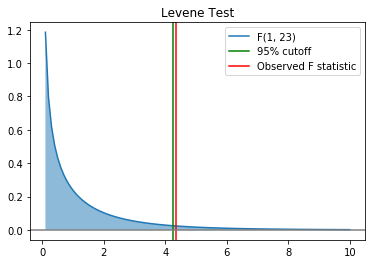

In [30]:
fstat = 4.355

x = np.linspace(0.1, 10, 100)

_ = plt.plot(
    x,
    stats.f.pdf(
        x, 1, len(res1.resid) + len(res2.resid) - 1
    ),
    '-',
    label=f'F(1, {len(res1.resid) + len(res2.resid)-1})',
)

_ = plt.fill_between(
    x,
    0,
    stats.f.pdf(
        x, 1, len(res1.resid) + len(res2.resid) - 1
    ),
    alpha=0.5,
)

_ = plt.axvline(f_crit, color='green', label='95% cutoff')
_ = plt.axvline(
    fstat, color='red', label='Observed F statistic'
)
_ = plt.axhline(0, color='gray')
_ = plt.legend(loc='best')
_ = plt.title('Levene Test')

### Fligner Test

Apply another test with different assumptions


    "Fligner’s test tests the null hypothesis that all input samples are from populations with equal variances. Fligner-Killeen’s test is distribution free when populations are identical [2]."

In [31]:
stats.fligner(res1.resid, res2.resid)

FlignerResult(statistic=5.669609800545504, pvalue=0.01726129518976522)

### F Test

Finally apply the F Test although:

     ... test is so sensitive to the assumption of normality

Compute F statistic

In [32]:
a, b = (
    np.var(res1.resid, ddof=1),
    np.var(res2.resid, ddof=1),
)
a, b
fstat = a / b
fstat

70.80436557004255

Probability of seeing this value or greater

In [33]:
fdist = stats.f(len(res1.resid) - 1, len(res2.resid))
p_value = 1 - fdist.cdf(fstat)
p_value

3.6332373776204463e-09

In [34]:
f_crit = stats.f.ppf(
    0.99, len(res1.resid) - 1, len(res2.resid)
)
f_crit

4.219819998398951

Plot the results

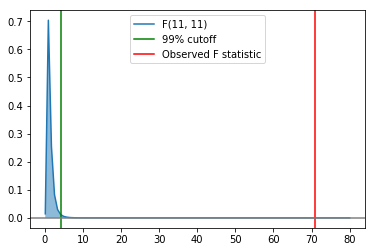

In [35]:
x = np.linspace(0.1, 80, 100)

_ = plt.plot(
    x,
    stats.f.pdf(
        x, len(res1.resid) - 1, len(res2.resid) - 1
    ),
    '-',
    label=f'F({len(res1.resid) - 1}, {len(res2.resid)-1})',
)

_ = plt.fill_between(
    x,
    0,
    stats.f.pdf(
        x, len(res1.resid) - 1, len(res2.resid) - 1
    ),
    alpha=0.5,
)

_ = plt.axvline(f_crit, color='green', label='99% cutoff')
_ = plt.axvline(
    fstat, color='red', label='Observed F statistic'
)
_ = plt.axhline(0, color='gray')
_ = plt.legend(loc='best')

---
## Conclusions

From our test results (at the 5% level), we can be confident that the improved jitter did not occur by chance, and that Hardware Averaging in the ADC  does improve stability of the readings. 

----
Environment

In [36]:
%watermark

%watermark -h -iv

2020-06-07T09:27:29+10:00

CPython 3.7.1
IPython 7.2.0

compiler   : MSC v.1915 64 bit (AMD64)
system     : Windows
release    : 10
machine    : AMD64
processor  : Intel64 Family 6 Model 94 Stepping 3, GenuineIntel
CPU cores  : 8
interpreter: 64bit
platform    1.0.8
statsmodels 0.9.0
numpy       1.15.4
seaborn     0.9.0
scipy       1.1.0
matplotlib  3.0.2
pandas      1.0.0
host name: DESKTOP-SODFUN6


In [37]:
# show info to support reproducibility

theNotebook = 'ADCAnalysis.ipynb'


def python_env_name():
    envs = subprocess.check_output(
        'conda env list'
    ).splitlines()
    # get unicode version of binary subprocess output
    envu = [x.decode('ascii') for x in envs]
    active_env = list(
        filter(lambda s: '*' in str(s), envu)
    )[0]
    env_name = str(active_env).split()[0]
    return env_name


# end python_env_name

print('python version     : ' + sys.version)
print('python environment :', python_env_name())

print('current wkg dir    : ' + os.getcwd())
print('Notebook name      : ' + theNotebook)
print(
    'Notebook run at    : '
    + str(datetime.datetime.now())
    + ' local time'
)
print(
    'Notebook run at    : '
    + str(datetime.datetime.utcnow())
    + ' UTC'
)
print('Notebook run on    : ' + platform.platform())

python version     : 3.7.1 (default, Dec 10 2018, 22:54:23) [MSC v.1915 64 bit (AMD64)]
python environment : ac5-py37
current wkg dir    : C:\Users\donrc\Documents\JupyterNotebooks\PythonNotebookProject\develop
Notebook name      : ADCAnalysis.ipynb
Notebook run at    : 2020-06-07 09:27:38.618146 local time
Notebook run at    : 2020-06-06 23:27:38.619144 UTC
Notebook run on    : Windows-10-10.0.18362-SP0
